# Movie Ppl
## aka The Poach List
### aka The Hit List

In this analysis, we'll be looking at the composite movie and ROI% data to find the top performers by ROI%, for each role in the movie business. 

"Role" is being defined as the various jobs done in the production of the movie, e.g. Actor, Director, Writer, etc.

In [769]:
# import necessary packages
import pandas as pd             # to work with dataframes
from ast import literal_eval    # to convert list-like strings into lists
import matplotlib.pyplot as plt # to make figures
%matplotlib inline
plt.style.use('seaborn-talk')

In [770]:
!ls

Dani                         movies.dat
DataClean_Nick.ipynb         movies_gross_clean.csv
Data_cleaning_marvel.ipynb   peoplefigs
Movie_analysis_final.ipynb   profitability_join.ipynb
Nick_movieppl_analysis.ipynb rating_analysis_marvel.ipynb
README.md                    ratings.dat
cleanIMDB                    raw_data_hist.png
data_cleaning_final.ipynb    theNumbers_clean.csv
images                       twitter_reviews_clean.csv
imdb_combined_prof.csv       zippedData


In [771]:
namekey = pd.read_csv('cleanIMDB/imdb_namekey.csv', index_col=0) # import name key

In [772]:
comp = pd.read_csv('imdb_combined_prof.csv') # import movie composite dataset - info and ROI % info

In [773]:
# remove unnecessary columns
comp.drop(axis=1, labels=['Unnamed: 0', 'Unnamed: 0_x', 'Unnamed: 0_y', 'id', 'concat'], inplace=True)

In [774]:
comp.columns

Index(['tconst', 'primary_title', 'original_title', 'start_year',
       'runtime_minutes', 'genres', 'averagerating', 'numvotes', 'directors',
       'writers', 'actor', 'actress', 'archive_footage', 'archive_sound',
       'cinematographer', 'composer', 'director_pr', 'editor', 'producer',
       'production_designer', 'self', 'writer_pr', 'release_date', 'movie',
       'production_budget', 'domestic_gross', 'worldwide_gross', 'ROI %',
       'ROI $', 'year', 'month', 'inflation', 'worldwide_gross_inf',
       'domestic_gross_inf', 'production_budget_inf', 'ROI $ Inf', 'ROI%_inf'],
      dtype='object')

## Step 1: Prepare dataframe for grouping

In [775]:
# if possible, convert list-looking strings into actual lists for downstream df.explode()
def lit_try(val):
    try:
        return literal_eval(val) # function which parses strings to find type
    except:
        return val # pass null values or other non-strings to avoid exceptions

In [776]:
comp.iloc[:,8:22] = comp.iloc[:,8:22].applymap(lit_try) # convert role column values into lists

In [777]:
# add two director columns together (columns from two different sources)
comp['director'] = comp['directors'] + comp['director_pr']

In [778]:
# add two writer columns together (columns from two different sources)
comp['writer'] = comp['writers'] + comp['writer_pr']

In [779]:
# add actor and actress columns to make gender neutral column
comp['actor/actress'] = comp['actor'] + comp['actress']

In [780]:
comp.columns

Index(['tconst', 'primary_title', 'original_title', 'start_year',
       'runtime_minutes', 'genres', 'averagerating', 'numvotes', 'directors',
       'writers', 'actor', 'actress', 'archive_footage', 'archive_sound',
       'cinematographer', 'composer', 'director_pr', 'editor', 'producer',
       'production_designer', 'self', 'writer_pr', 'release_date', 'movie',
       'production_budget', 'domestic_gross', 'worldwide_gross', 'ROI %',
       'ROI $', 'year', 'month', 'inflation', 'worldwide_gross_inf',
       'domestic_gross_inf', 'production_budget_inf', 'ROI $ Inf', 'ROI%_inf',
       'director', 'writer', 'actor/actress'],
      dtype='object')

### Select most important roles

Of all the available roles, let's select all but the production designer, archive footage, archive sound, and self

In [781]:
# list of roles we want to analyze
pplorder = ['actor','actress','actor/actress','director','writer','producer','cinematographer','editor','composer']

## Step 2: Group movies by person, for each role

Because the process to analyze the data is so similar across the various roles we're interested in, I'm going to write a loop that does all the analyses iteratively for each role `ppl` (people) in `pplorder`.

This will use two dictionaries:

1. `ppldfdictpre` has key `ppl` for each item in `pplorder`, for value dataframe which results from the original `comp` composite dataframe exploded on the column named `ppl`. This will be used for downstream calculation of the career ROI% for each person, done by using the sums of the worldwide gross and budget numbers for all the movies each person has worked on, `ROI_careertot%`. This will also be used to get the number of movies each person (in role `ppl`) worked on, `movie_count`.
2. `ppldfdict` has key `ppl` for each item in `pplorder`, for value dataframe which results from the original `comp` composite dataframe, grouped by individual person id value (`nconst` in `namekey` dataframe) in column `ppl`, and the means for all the numerical columns of these groups. The resulting dataframe is trimmed to only include necessary columns for downstream analysis: `start_year`, `runtime_minutes`, `averagerating`, `numvotes`, `worldwide_gross_inf`, `production_budget_inf`, `ROI_careertot%`, and `movie_count`.

In [782]:
# create dictionaries to store a dataframe (value) for each role (key)
ppldfdictpre = {} # initialize dictionary for explode/drop_duplicates step
ppldfdict = {}    # initialize dictionary to store end result

for ppl in pplorder: # loop over each role (`ppl`) in `pplorder`
    
    # for each role (`ppl`):

    # explode lists present in the column named `ppl` in composite dataframe (`comp`)
    # drop the duplicates ("director" & "writer" in particular was expected to have dupes)
        # (duplicates found by subset to avoid list error with other `ppl` columns in `comp`)
    # store the resulting dataframe as a value with key `ppl` in `ppldfdictpre` dictionary
    ppldfdictpre[ppl] = comp.explode(ppl).drop_duplicates(subset=['tconst','primary_title','start_year',ppl])
    
    # for key `ppl` in `ppldfdictpre` dictionary, take the value dataframe
    # group the `ppl` column by name id value (`nconst` in `namekey` dataframe)
    # take the mean of the aggregated groups' numerical columns
    # store the resulting dataframe as a value with key `ppl` in `ppldfdict` dictionary
    ppldfdict[ppl] = ppldfdictpre[ppl].groupby(ppl).mean()
    
    # for key `ppl` in `ppldfdictpre` dictionary, take the value dataframe
    # group the `ppl` column by name id value (`nconst` in `namekey` dataframe)
    # take the sum of the aggregated groups' numerical columns
    # do series math: 
        # use those summed columns to calculate ROI% with `worldwide_gross_inf` and `production_budget_inf`
    # store the resulting series as column `ROI_careertot%` in `ppldfdict[ppl]`
    ppldfdict[ppl]['ROI_careertot%'] = (ppldfdictpre[ppl].groupby(ppl).sum()['worldwide_gross_inf'] -\
                                     ppldfdictpre[ppl].groupby(ppl).sum()['production_budget_inf']) /\
                                     ppldfdictpre[ppl].groupby(ppl).sum()['production_budget_inf']*100
    
    # for key `ppl` in `ppldfdictpre` dictionary, take the value dataframe
    # group the `ppl` column by name id value (`nconst` in `namekey` dataframe)
    # get the number of rows per aggregated group with .size()
    ppldfdict[ppl]['movie_count'] = ppldfdictpre[ppl].groupby(ppl).size()
    
    # for key `ppl` in `ppldfdict` dictionary, sort by `ROI_careertot%` descending
    ppldfdict[ppl]= ppldfdict[ppl].sort_values(by='ROI_careertot%',ascending=False)
    
    # for key `ppl` in `ppldfdict` dictionary, trim columns to only what we need downstream
    ppldfdict[ppl] = ppldfdict[ppl][['start_year','runtime_minutes','averagerating','numvotes','worldwide_gross_inf',\
                                     'production_budget_inf','ROI_careertot%','movie_count']]

## Step 3: Merge with name info

Now we'll use the `namekey` dataframe to yield the name info for each `nconst` value in the `ppl` role dataframes.

In [783]:
# merge the role dataframes with the name info
ppl_comp = {} # dictionary for composite people dataframes
ppl_nums = {} # dictionary for counts of each dataframe
for ppl in ppldfdict.keys():
    ppl_comp[ppl] = ppldfdict[ppl].merge(namekey, how='left', left_on=ppl, right_on='nconst')
    ppl_nums[ppl] = len(ppl_comp[ppl]) # number of people in each role

## Step 4: Filter dataframes for people with 2+ and 3+ movies worked on

Because people might only have one successful movie to their name, aka 'one-hit wonders', let's filter the original dataset for at least 2 and at least 3 movies. At least 3 movies was done for exploratory purposes, but is ultimately deemed extraneous. I have kept it here anyways.

Create 2 new pairs of dictionaries:
1. `ppl_comp2` and `ppl2_nums`
2. `ppl_comp3` and `ppl3_nums`

In [784]:
# removing people with only one movie to their name - 'one-hit wonders'
# people with movie_count >= 2
ppl_comp2 = {}
ppl2_nums = {}
for ppl in ppl_comp.keys():
    ppl_comp2[ppl] = ppl_comp[ppl][ppl_comp[ppl]['movie_count'] >= 2]
    ppl2_nums[ppl] = len(ppl_comp2[ppl]) # number of people in each role

In [785]:
# people with movie_count >= 3
ppl_comp3 = {}
ppl3_nums = {}
for ppl in ppl_comp.keys():
    ppl_comp3[ppl] = ppl_comp[ppl][ppl_comp[ppl]['movie_count'] >= 3]
    ppl3_nums[ppl] = len(ppl_comp3[ppl]) # number of people in each role

## Step 5: Find average movie counts and %ROI for each dataframe in all three dictionaries
Create 3 new dictionaries:
1. `ppl_comp_avgs`
2. `ppl_comp2_avgs`
3. `ppl_comp3_avgs`

In [786]:
ppl_comp_avgs = {}
for ppl in ppl_comp.keys():
    ppl_comp_avgs[f'{ppl}_movie_count'] = ppl_comp[ppl]['movie_count'].mean()
    ppl_comp_avgs[f'{ppl}_%ROI_avg'] = ppl_comp[ppl]['ROI_careertot%'].mean()

In [787]:
ppl_comp2_avgs = {}
for ppl in ppl_comp2.keys():
    ppl_comp2_avgs[f'{ppl}_movie_count'] = ppl_comp2[ppl]['movie_count'].mean()
    ppl_comp2_avgs[f'{ppl}_%ROI_avg'] = ppl_comp2[ppl]['ROI_careertot%'].mean()

In [788]:
ppl_comp3_avgs = {}
for ppl in ppl_comp3.keys():
    ppl_comp3_avgs[f'{ppl}_movie_count'] = ppl_comp3[ppl]['movie_count'].mean()
    ppl_comp3_avgs[f'{ppl}_%ROI_avg'] = ppl_comp3[ppl]['ROI_careertot%'].mean()

## Step 6: Visualize # of Movies vs. %ROI for each role using a scatterplot

\# of movies is used a proxy for consistent success in people's various roles. For example, one movie might just be a fluke, aka "One Hit Wonder" status.

Because all the dataframes are stored as dictionaries, it will be easy to iterate through them to quickly make a collection of figures.

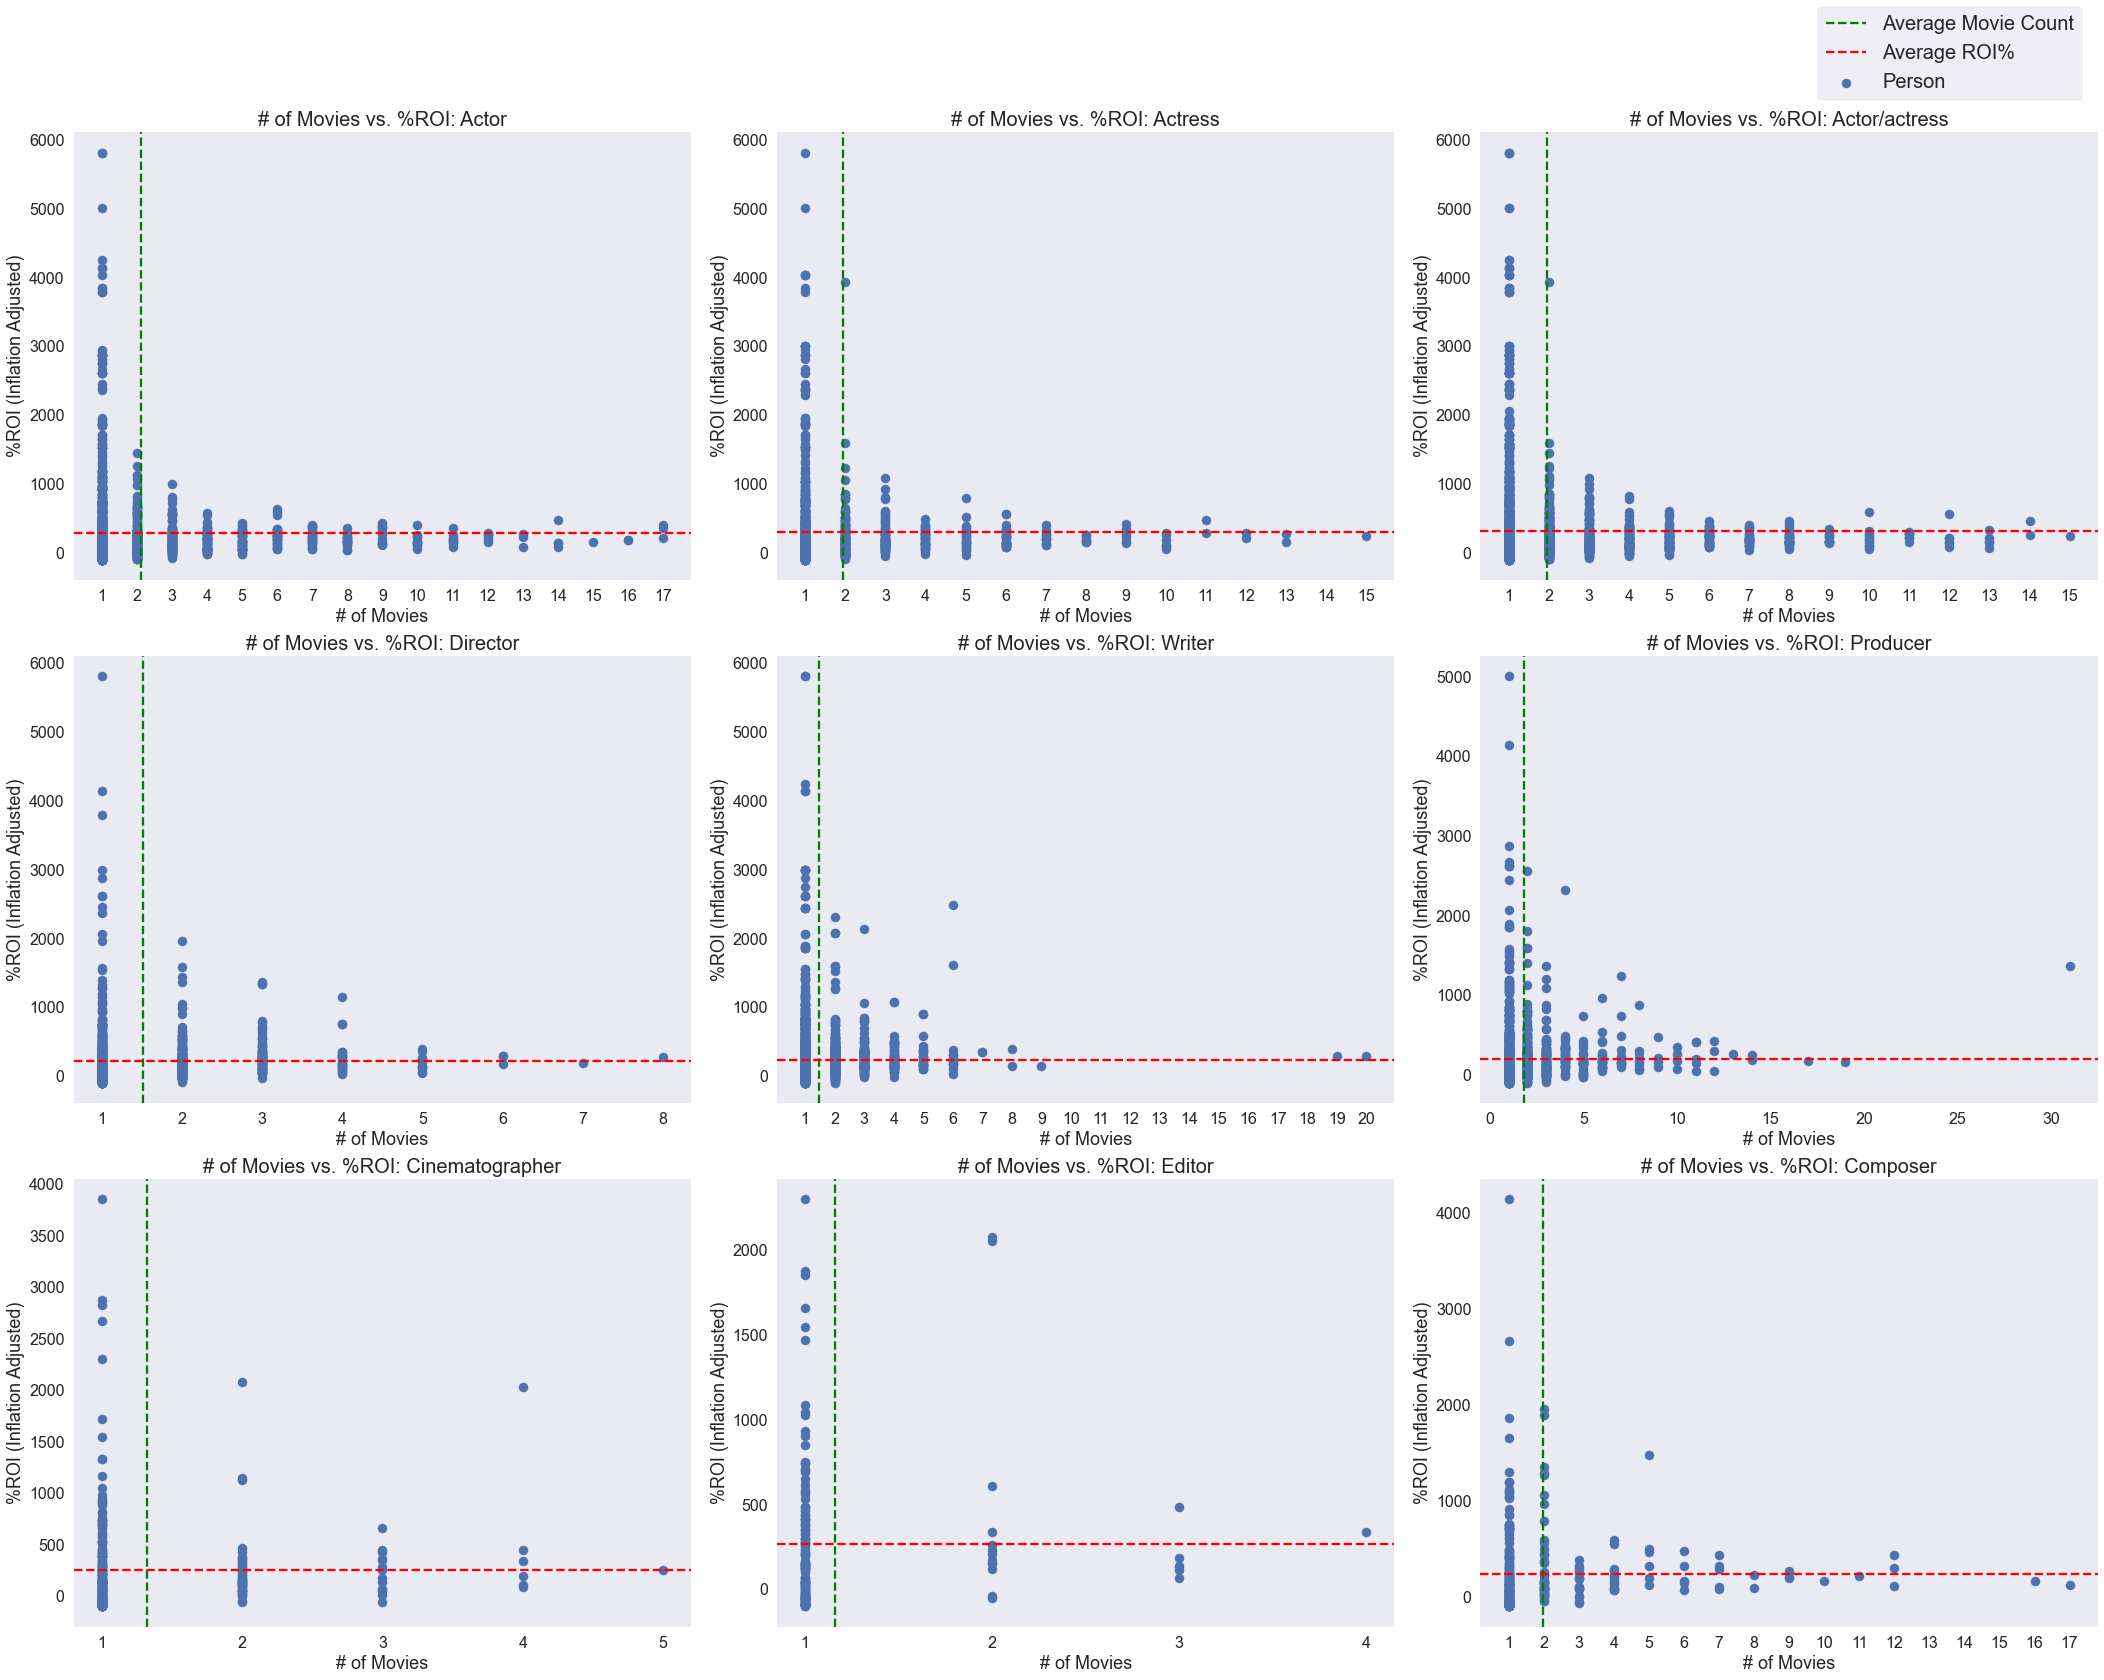

In [789]:
# all # of movies

# create figure
fig, ax = plt.subplots(3, 3, figsize=[30,22.5])
plt.tight_layout(pad=5)

# get index `i` for plotting purposes, `ppl` for dataframe data purposes
for i,ppl in enumerate(pplorder):
    
    # to orient the figure in the correct subplot
    r = i//3
    c = i%3
    
    # plot the data in `ppl` dataframes from `ppl_comp`
    # `movie_count` on x, `ROI_careertot%` on y
    ax[r,c].scatter(x=ppl_comp[ppl]['movie_count'],y=ppl_comp[ppl]['ROI_careertot%'], label='Person')
    
    # plot averages in `ppl_comp_avgs`
    # `f'{ppl}_movie_count'` vertical line
    # `f'{ppl}_%ROI_avg'` horizontal line
    ax[r,c].axvline(ppl_comp_avgs[f'{ppl}_movie_count'], ls='--', color='green', label='Average Movie Count')
    ax[r,c].axhline(ppl_comp_avgs[f'{ppl}_%ROI_avg'], ls='--', color='red', label='Average ROI%')
    
    # remove grid to reduce busy-ness
    ax[r,c].grid(False)
    
    # labels and title
    ax[r,c].set_xlabel('# of Movies', fontsize=18)
    ax[r,c].set_ylabel('%ROI (Inflation Adjusted)', fontsize=18)
    ax[r,c].set_title(f'# of Movies vs. %ROI: {ppl.capitalize()}', fontsize=20)
    ax[r,c].tick_params(axis='both', which='major', labelsize=16)
    
    # set ticks in increments of 1, except 'producer', which is 5 due to high movie counts
    if ppl == 'producer':
        ax[r,c].xaxis.set_major_locator(plt.MultipleLocator(5))
    else:
        ax[r,c].xaxis.set_major_locator(plt.MultipleLocator(1))

# label the whole figure outside the subplots to reduce busy-ness
lines, labels = fig.axes[0].get_legend_handles_labels()
fig.legend(lines, labels, bbox_to_anchor=(0.97,0.98), loc='lower right', fontsize=20, frameon=True)

# save the figure
plt.savefig('peoplefigs/movie_roi_scatter_allmov.png')

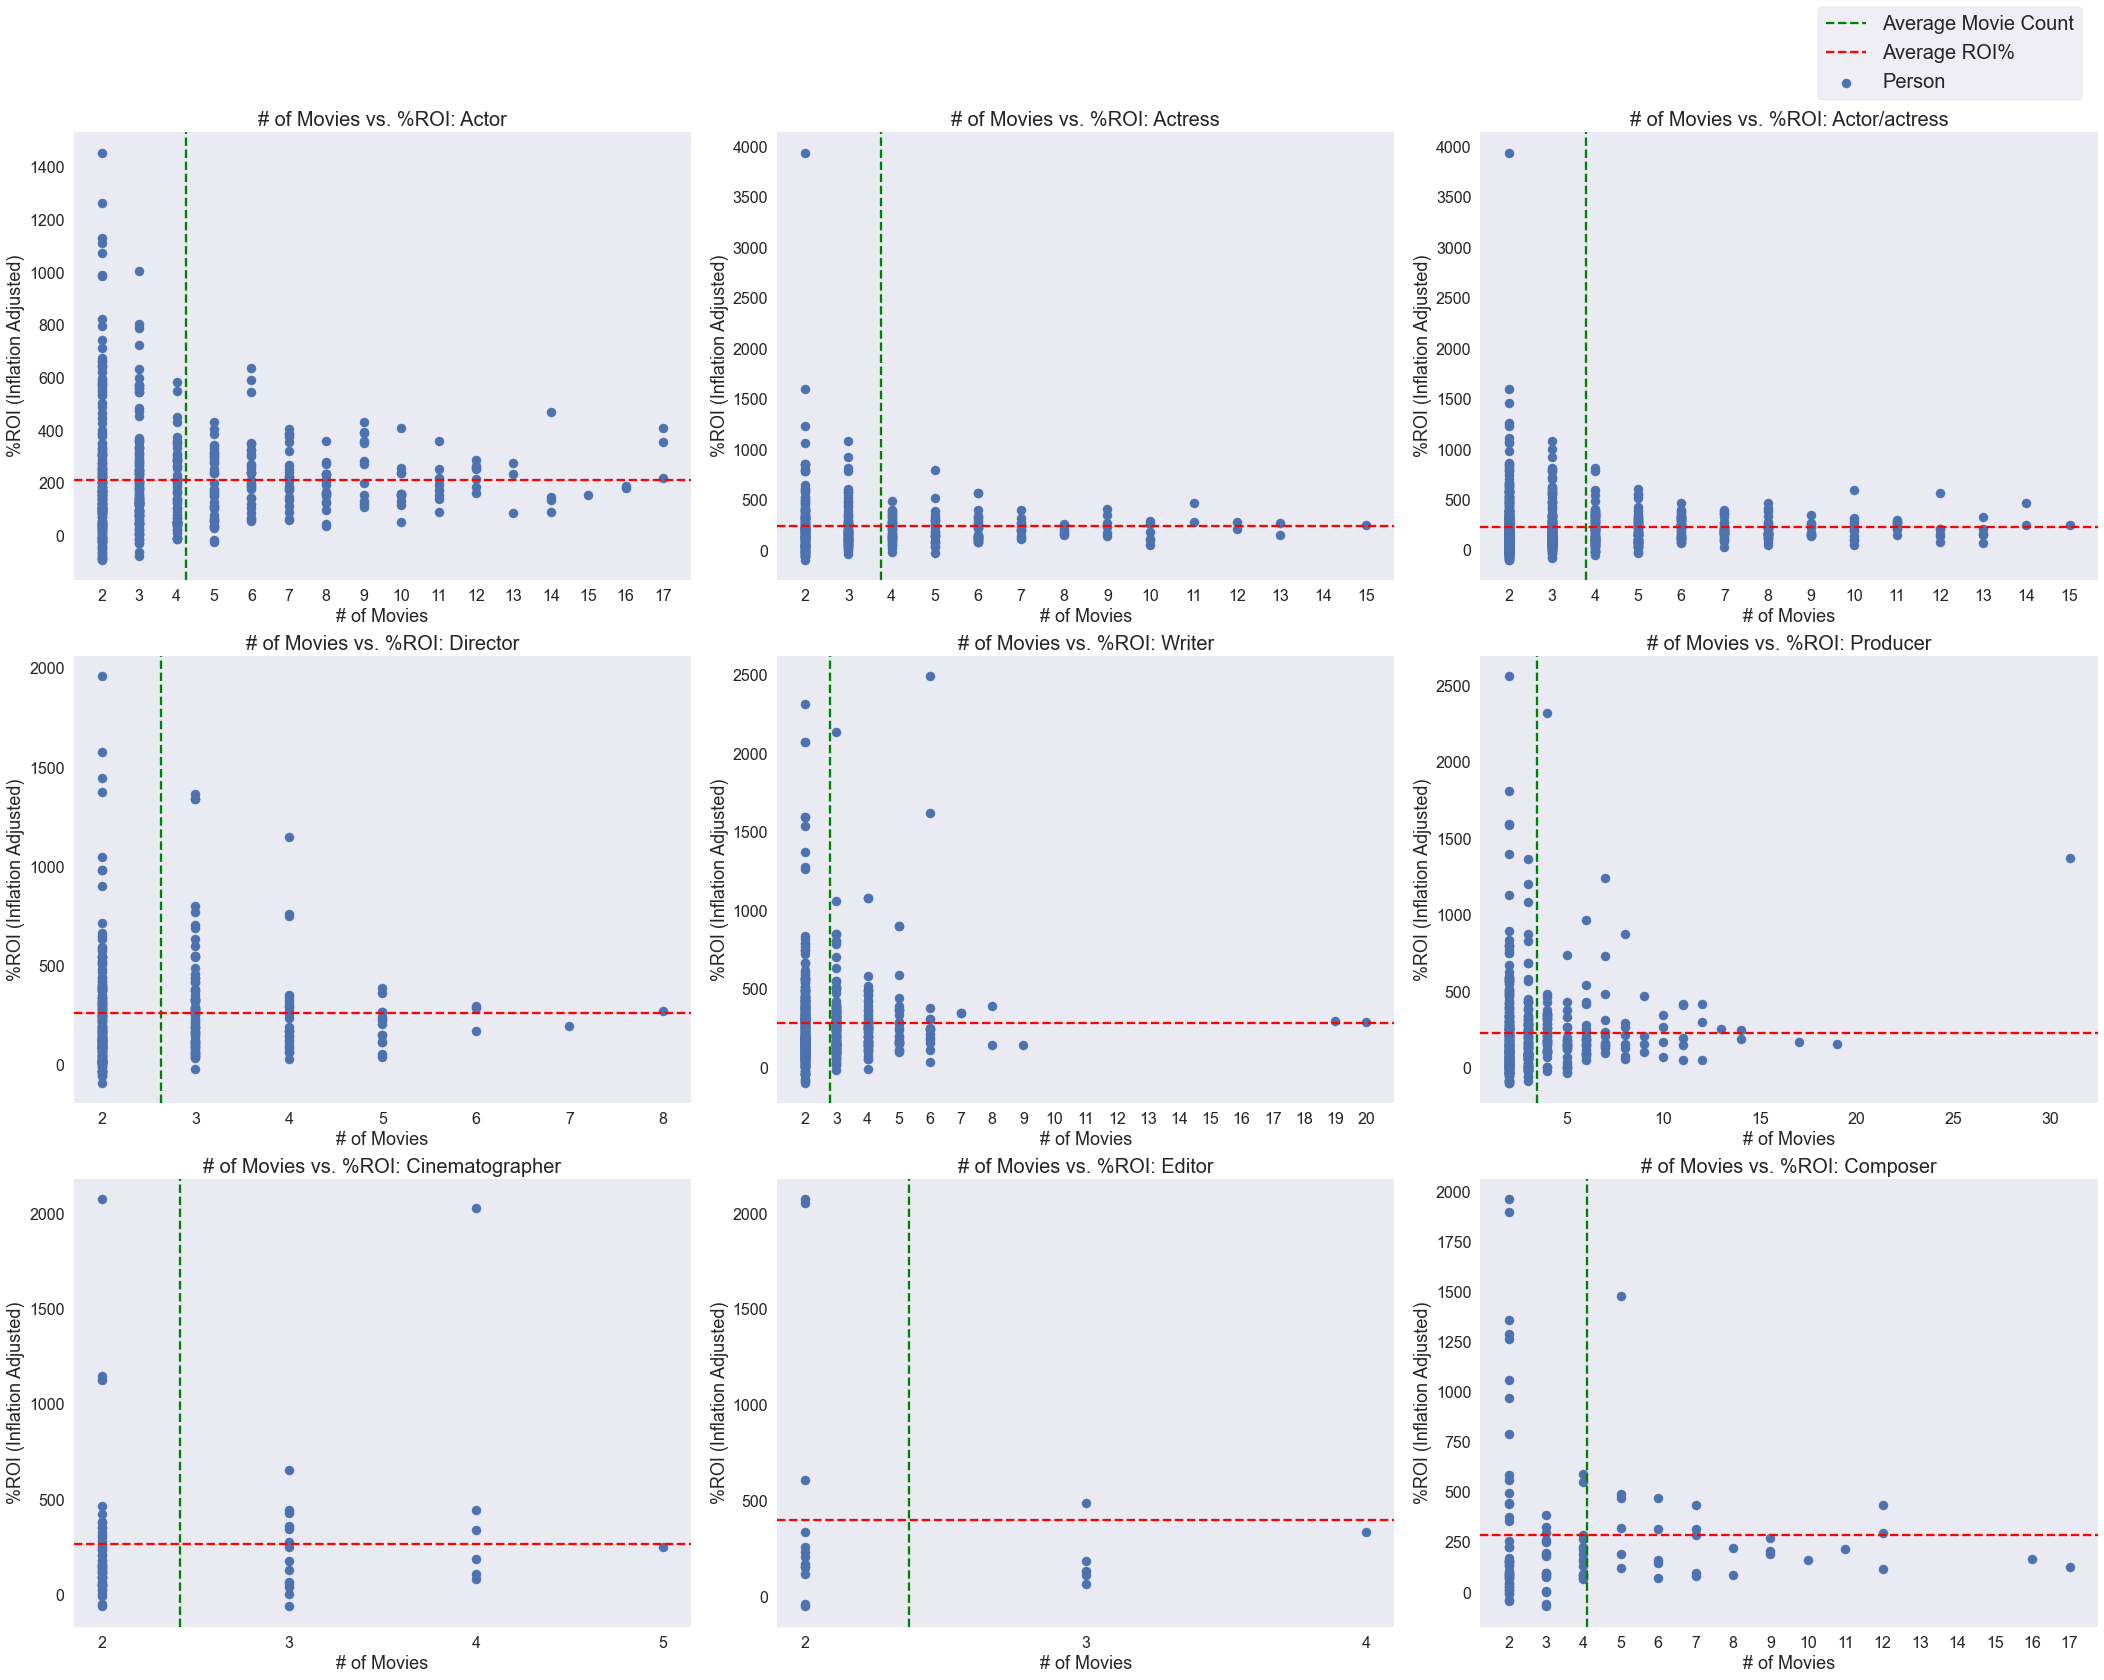

In [790]:
# at least 2 movies

# create figure
fig, ax = plt.subplots(3, 3, figsize=[30,22.5])
plt.tight_layout(pad=5)

# get index `i` for plotting purposes, `ppl` for dataframe data purposes
for i,ppl in enumerate(pplorder):
    
    # to orient the figure in the correct subplot
    r = i//3
    c = i%3
    
    # plot the data in `ppl` dataframes from `ppl_comp2`
    # `movie_count` on x, `ROI_careertot%` on y
    ax[r,c].scatter(x=ppl_comp2[ppl]['movie_count'],y=ppl_comp2[ppl]['ROI_careertot%'], label='Person')
    
    # plot averages in `ppl_comp2_avgs`
    # `f'{ppl}_movie_count'` vertical line
    # `f'{ppl}_%ROI_avg'` horizontal line
    ax[r,c].axvline(ppl_comp2_avgs[f'{ppl}_movie_count'], ls='--', color='green', label='Average Movie Count')
    ax[r,c].axhline(ppl_comp2_avgs[f'{ppl}_%ROI_avg'], ls='--', color='red', label='Average ROI%')
    
    # remove grid to reduce busy-ness
    ax[r,c].grid(False)
    
    # labels and title
    ax[r,c].set_xlabel('# of Movies', fontsize=18)
    ax[r,c].set_ylabel('%ROI (Inflation Adjusted)', fontsize=18)
    ax[r,c].set_title(f'# of Movies vs. %ROI: {ppl.capitalize()}', fontsize=20)
    ax[r,c].tick_params(axis='both', which='major', labelsize=16)
    
    # set ticks in increments of 1, except 'producer', which is 5 due to high movie counts
    if ppl == 'producer':
        ax[r,c].xaxis.set_major_locator(plt.MultipleLocator(5))
    else:
        ax[r,c].xaxis.set_major_locator(plt.MultipleLocator(1))

# label the whole figure outside the subplots to reduce busy-ness
lines, labels = fig.axes[0].get_legend_handles_labels()
fig.legend(lines, labels, bbox_to_anchor=(0.97,0.98), loc='lower right', fontsize=20, frameon=True)

# save the figure
plt.savefig('peoplefigs/movie_roi_scatter_2plusmov.png')

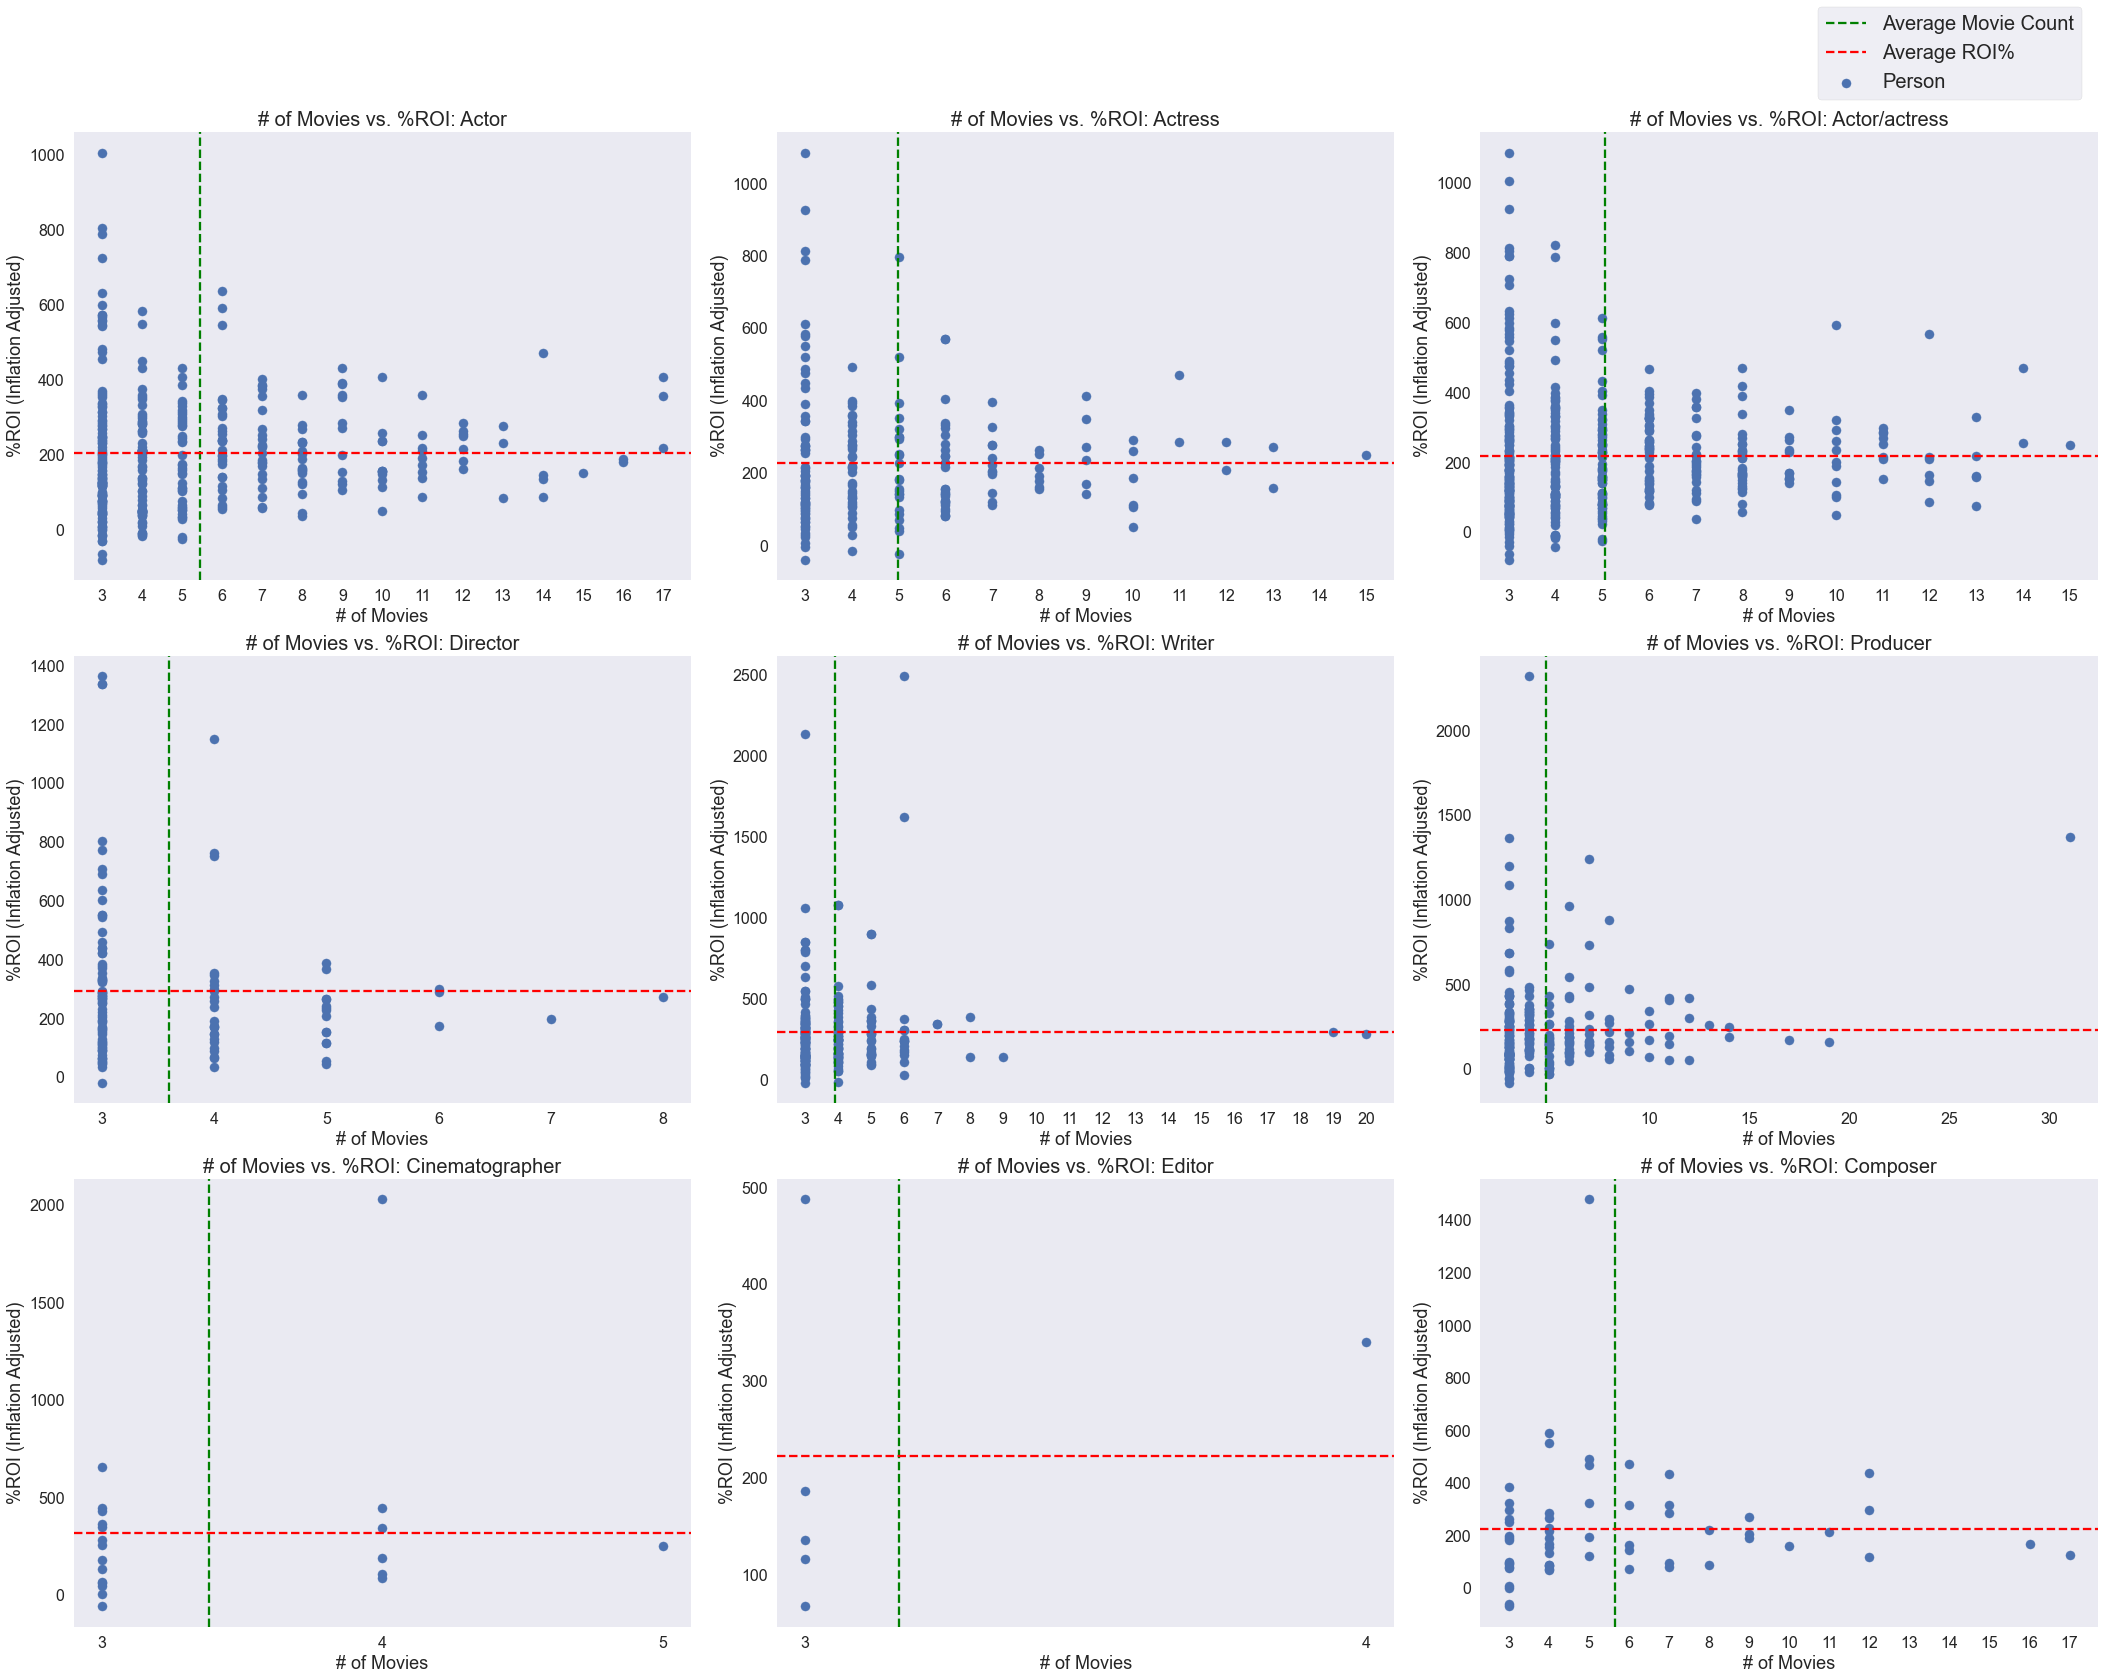

In [791]:
# at least 3 movies

# create figure
fig, ax = plt.subplots(3, 3, figsize=[30,22.5])
plt.tight_layout(pad=5)

# get index `i` for plotting purposes, `ppl` for dataframe data purposes
for i,ppl in enumerate(pplorder):
    
    # to orient the figure in the correct subplot
    r = i//3
    c = i%3
    
    # plot the data in `ppl` dataframes from `ppl_comp3`
    # `movie_count` on x, `ROI_careertot%` on y
    ax[r,c].scatter(x=ppl_comp3[ppl]['movie_count'],y=ppl_comp3[ppl]['ROI_careertot%'], label='Person')
    
    # plot averages in `ppl_comp3_avgs`
    # `f'{ppl}_movie_count'` vertical line
    # `f'{ppl}_%ROI_avg'` horizontal line
    ax[r,c].axvline(ppl_comp3_avgs[f'{ppl}_movie_count'], ls='--', color='green', label='Average Movie Count')
    ax[r,c].axhline(ppl_comp3_avgs[f'{ppl}_%ROI_avg'], ls='--', color='red', label='Average ROI%')
    
    # remove grid to reduce busy-ness
    ax[r,c].grid(False)
    
    # labels and title
    ax[r,c].set_xlabel('# of Movies', fontsize=18)
    ax[r,c].set_ylabel('%ROI (Inflation Adjusted)', fontsize=18)
    ax[r,c].set_title(f'# of Movies vs. %ROI: {ppl.capitalize()}', fontsize=20)
    ax[r,c].tick_params(axis='both', which='major', labelsize=16)
    
    # set ticks in increments of 1, except 'producer', which is 5 due to high movie counts
    if ppl == 'producer':
        ax[r,c].xaxis.set_major_locator(plt.MultipleLocator(5))
    else:
        ax[r,c].xaxis.set_major_locator(plt.MultipleLocator(1))

# label the whole figure outside the subplots to reduce busy-ness
lines, labels = fig.axes[0].get_legend_handles_labels()
fig.legend(lines, labels, bbox_to_anchor=(0.97,0.98), loc='lower right', fontsize=20, frameon=True)

# save the figure
plt.savefig('peoplefigs/movie_roi_scatter_3plusmov.png')

## Step 7: Plot top performers in each role in a bar graph

Now we can hone in on the 5 best people in each role and compare them on one axis: ROI%

In [792]:
# grab top 5 names in each position, for the three movie number cutoffs
ppl_compT = {}
ppl_comp2T = {}
ppl_comp3T = {}

for ppl in ppl_comp.keys():
    ppl_compT[ppl] = ppl_comp[ppl].head(5)

for ppl in ppl_comp2.keys():
    ppl_comp2T[ppl] = ppl_comp2[ppl].head(5)

for ppl in ppl_comp3.keys():
    ppl_comp3T[ppl] = ppl_comp3[ppl].head(5)

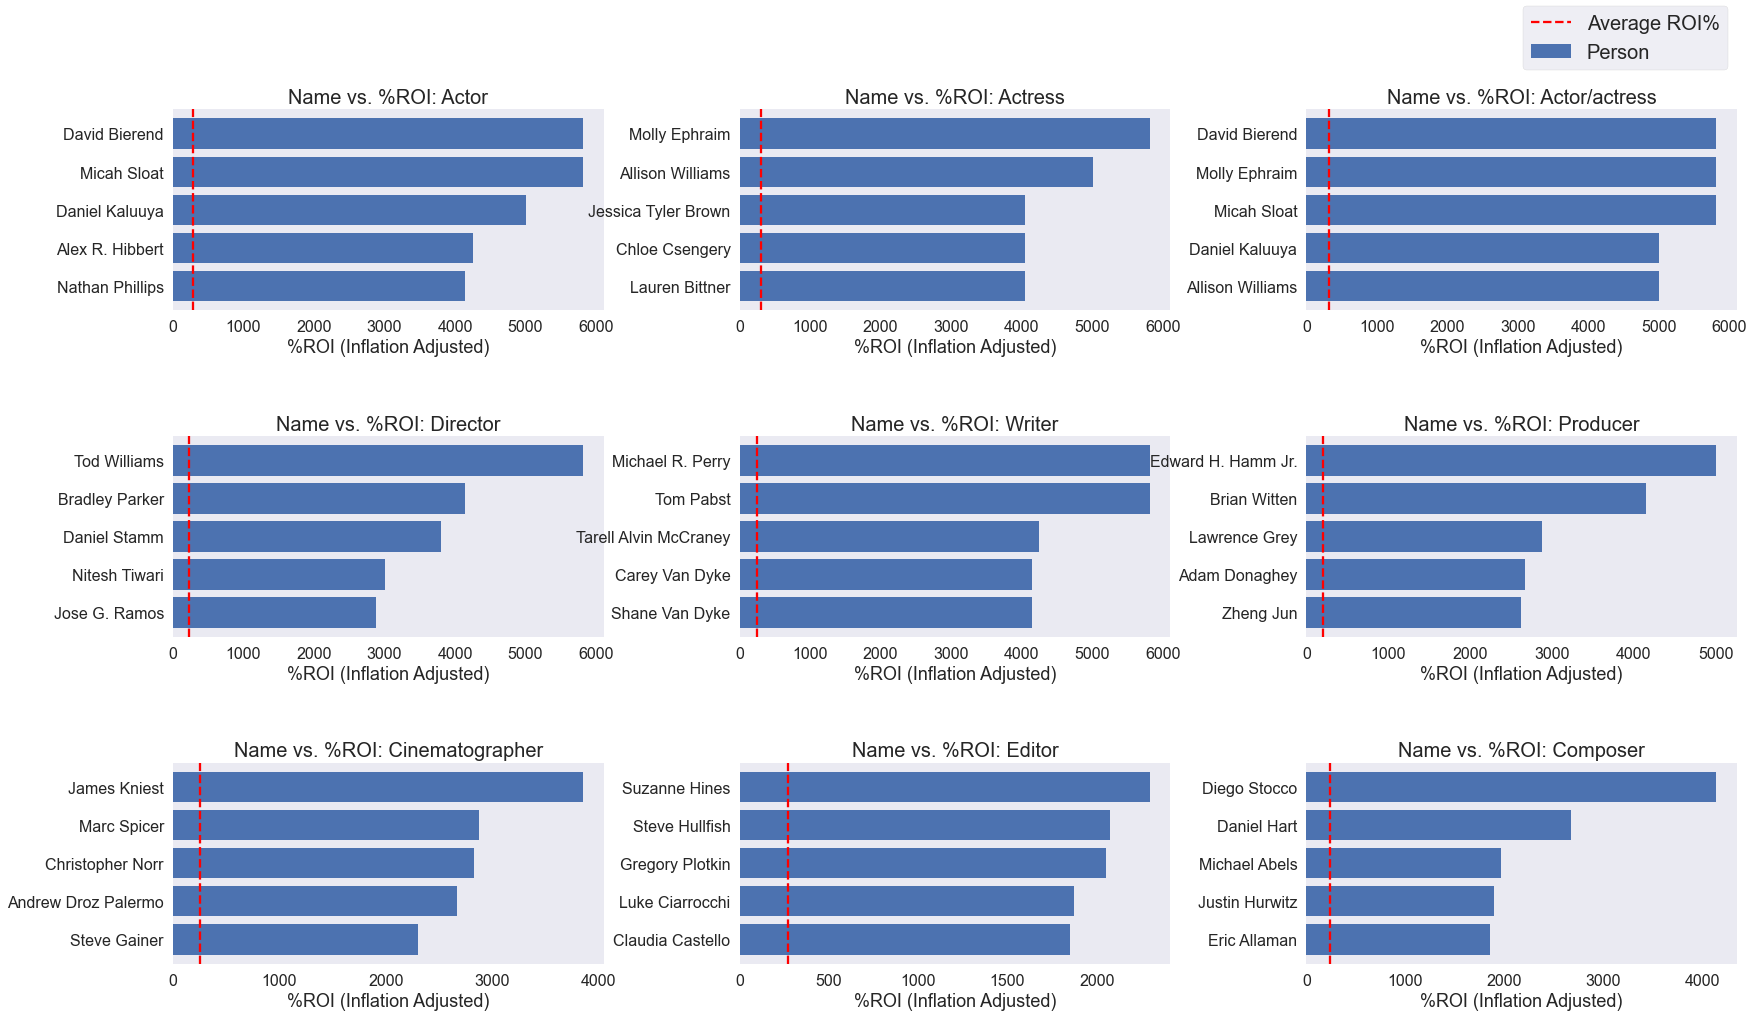

In [793]:
# all # of movies

# create figure
fig, ax = plt.subplots(3, 3, figsize=[25,15])
plt.tight_layout(pad=10)

# get index `i` for plotting purposes, `ppl` for dataframe data purposes
for i,ppl in enumerate(pplorder):
    
    # to orient the figure in the correct subplot
    r = i//3
    c = i%3
    
    # plot the data in `ppl` dataframes from `ppl_compT`
    # `ROI_careertot%` as width, `primary_name` as label pn y axis
    ax[r,c].barh(y=ppl_compT[ppl]['primary_name'],width=ppl_compT[ppl]['ROI_careertot%'], label='Person')
    ax[r,c].invert_yaxis()
    
    # remove grid to reduce busy-ness
    ax[r,c].grid(False)
    
    # plot average ROI% as horizontal line 
    # `f'{ppl}_%ROI_avg'` in `ppl_comp_avgs`
    ax[r,c].axvline(ppl_comp_avgs[f'{ppl}_%ROI_avg'], ls='--', color='red', label='Average ROI%')
    
    # labels and title
    ax[r,c].set_xlabel('%ROI (Inflation Adjusted)', fontsize=18)
    ax[r,c].set_title(f'Name vs. %ROI: {ppl.capitalize()}', fontsize=20)
    ax[r,c].tick_params(axis='both', which='major', labelsize=16)
    
# label the whole figure outside the subplots to reduce busy-ness
lines, labels = fig.axes[0].get_legend_handles_labels()
fig.legend(lines, labels, bbox_to_anchor=(0.94,0.93), loc='lower right', fontsize=20, frameon=True)

# save the figure
plt.savefig('peoplefigs/name_roi_bar_allmov.png')

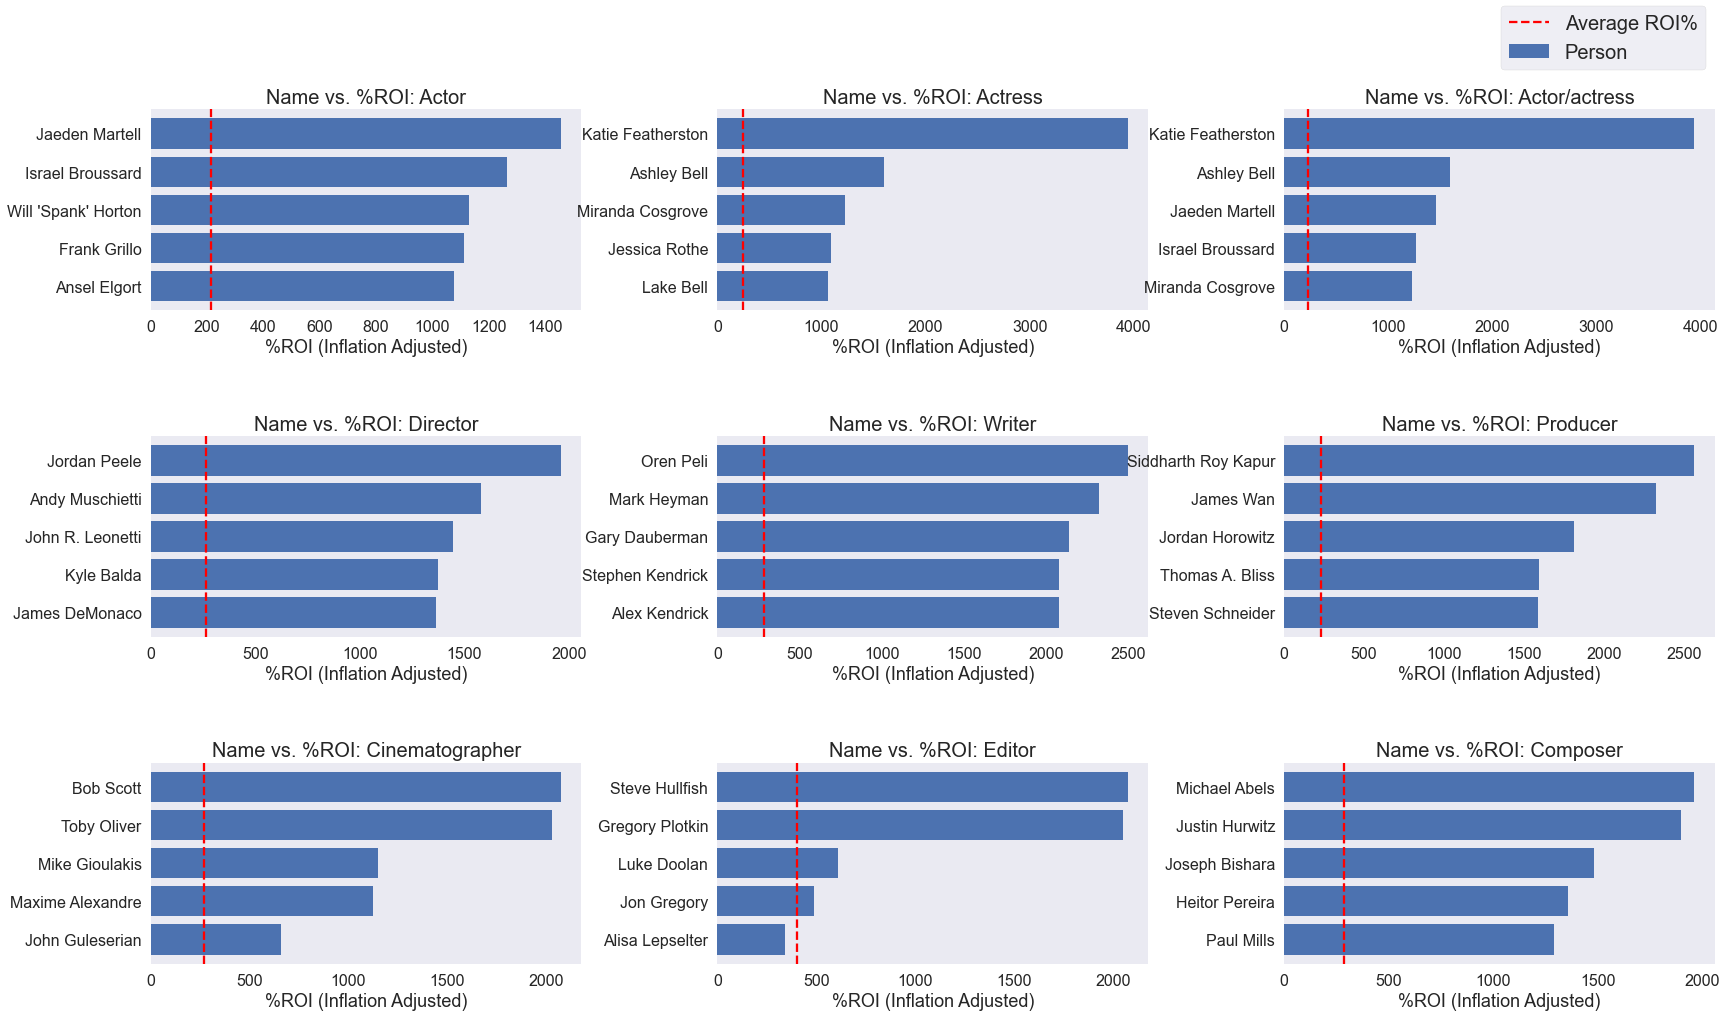

In [794]:
# at least 2 movies

# create figure
fig, ax = plt.subplots(3, 3, figsize=[25,15])
plt.tight_layout(pad=10)

# get index `i` for plotting purposes, `ppl` for dataframe data purposes
for i,ppl in enumerate(pplorder):
    
    # to orient the figure in the correct subplot
    r = i//3
    c = i%3
    
    # plot the data in `ppl` dataframes from `ppl_comp2T`
    # `ROI_careertot%` as width, `primary_name` as label pn y axis
    ax[r,c].barh(y=ppl_comp2T[ppl]['primary_name'],width=ppl_comp2T[ppl]['ROI_careertot%'], label='Person')
    ax[r,c].invert_yaxis()
    
    # remove grid to reduce busy-ness
    ax[r,c].grid(False)
    
    # plot average ROI% as horizontal line 
    # `f'{ppl}_%ROI_avg'` in `ppl_comp2_avgs`
    ax[r,c].axvline(ppl_comp2_avgs[f'{ppl}_%ROI_avg'], ls='--', color='red', label='Average ROI%')
    
    # labels and title
    ax[r,c].set_xlabel('%ROI (Inflation Adjusted)', fontsize=18)
    ax[r,c].set_title(f'Name vs. %ROI: {ppl.capitalize()}', fontsize=20)
    ax[r,c].tick_params(axis='both', which='major', labelsize=16)
    
# label the whole figure outside the subplots to reduce busy-ness
lines, labels = fig.axes[0].get_legend_handles_labels()
fig.legend(lines, labels, bbox_to_anchor=(0.94,0.93), loc='lower right', fontsize=20, frameon=True)

# save the figure
plt.savefig('peoplefigs/name_roi_bar_2plusmov.png')

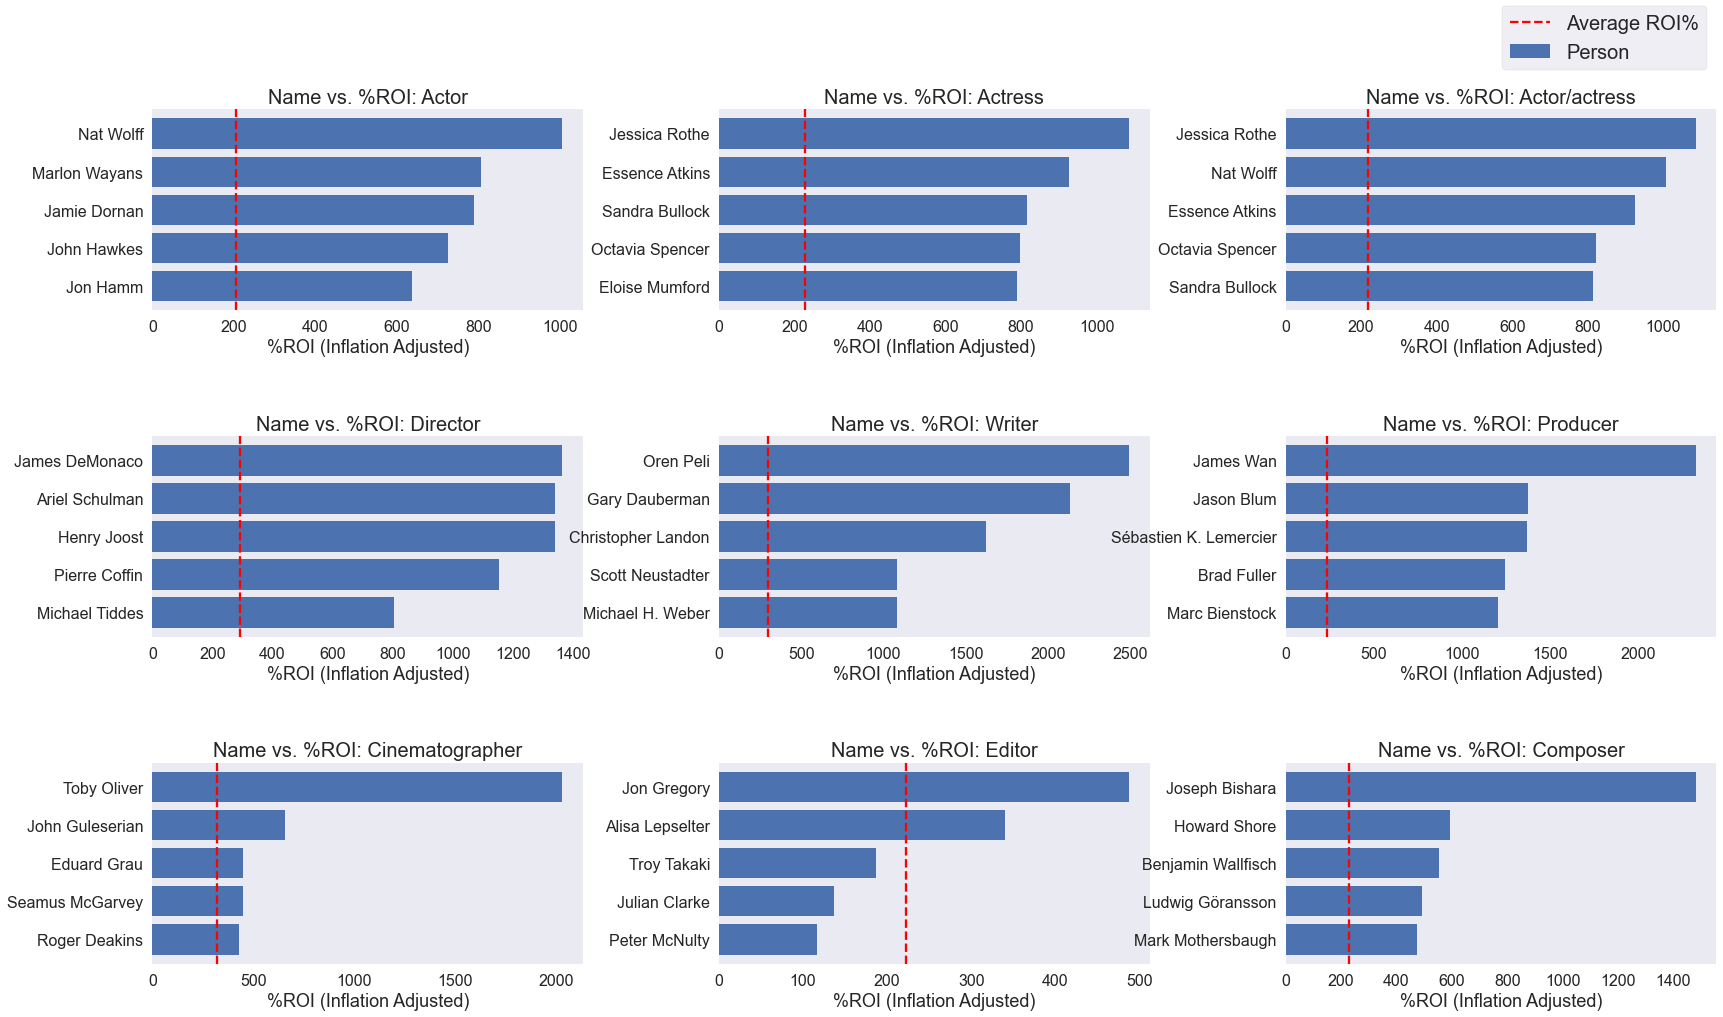

In [795]:
# at least 3 movies

# create figure
fig, ax = plt.subplots(3, 3, figsize=[25,15])
plt.tight_layout(pad=10)

# get index `i` for plotting purposes, `ppl` for dataframe data purposes
for i,ppl in enumerate(pplorder):
    
    # to orient the figure in the correct subplot
    r = i//3
    c = i%3
    
    # plot the data in `ppl` dataframes from `ppl_comp3T`
    # `ROI_careertot%` as width, `primary_name` as label pn y axis
    ax[r,c].barh(y=ppl_comp3T[ppl]['primary_name'],width=ppl_comp3T[ppl]['ROI_careertot%'], label='Person')
    ax[r,c].invert_yaxis()
    
    # remove grid to reduce busy-ness
    ax[r,c].grid(False)
    
    # plot average ROI% as horizontal line 
    # `f'{ppl}_%ROI_avg'` in `ppl_comp2_avgs`
    ax[r,c].axvline(ppl_comp3_avgs[f'{ppl}_%ROI_avg'], ls='--', color='red', label='Average ROI%')
    
    # labels and title
    ax[r,c].set_xlabel('%ROI (Inflation Adjusted)', fontsize=18)
    ax[r,c].set_title(f'Name vs. %ROI: {ppl.capitalize()}', fontsize=20)
    ax[r,c].tick_params(axis='both', which='major', labelsize=16)
    
# label the whole figure outside the subplots to reduce busy-ness
lines, labels = fig.axes[0].get_legend_handles_labels()
fig.legend(lines, labels, bbox_to_anchor=(0.94,0.93), loc='lower right', fontsize=20, frameon=True)

# save the figure
plt.savefig('peoplefigs/name_roi_bar_3plusmov.png')

## Step 8: Select the standouts of all roles

For at least 2 movies made, the standouts are in actor/actress, director, producer, and editor roles.

Standouts means that their ROI% is significantly greater than the other people close to them in that role.

In [796]:
finalppl = ['actor/actress','director','producer','editor']

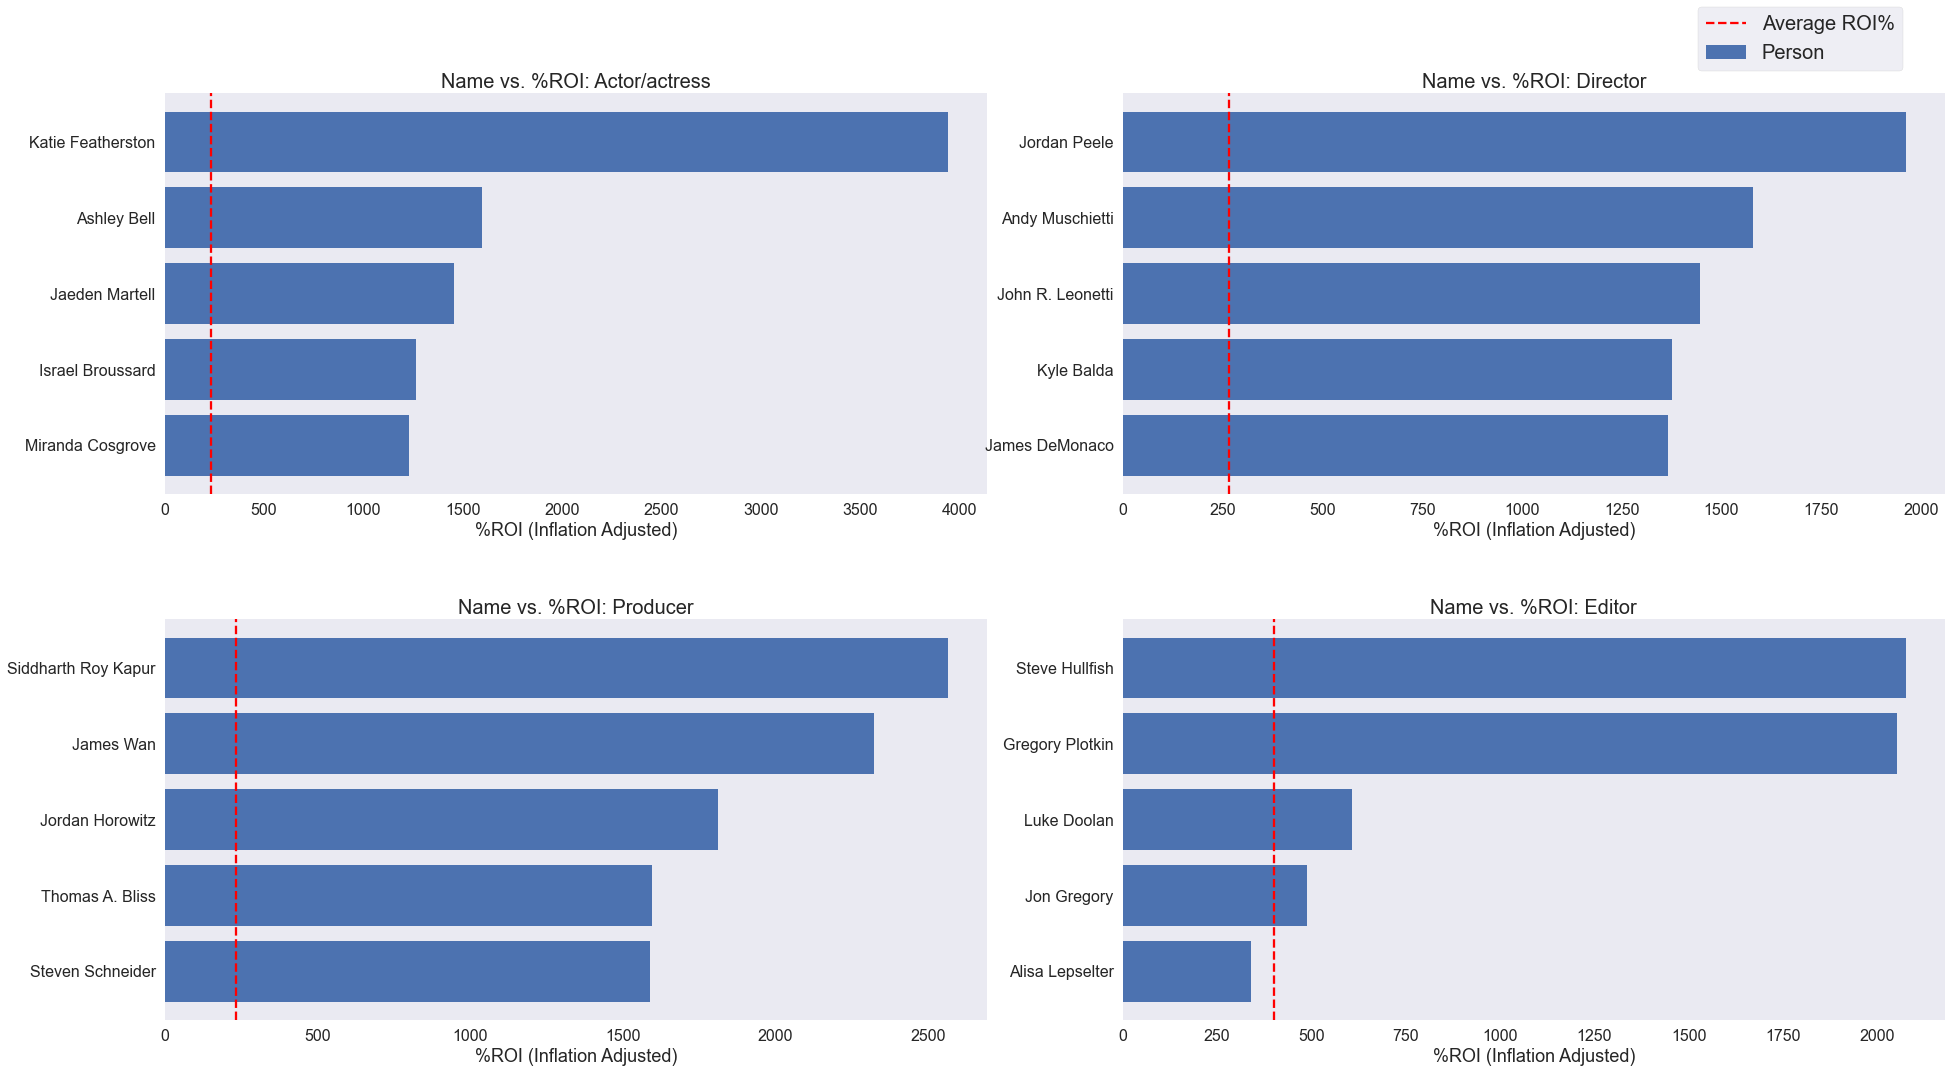

In [797]:
# create figure
fig, ax = plt.subplots(2, 2, figsize=[28,16])
plt.tight_layout(pad=10)

# get index `i` for plotting purposes, `ppl` for dataframe data purposes
# from the list of `ppl` keys in `finalppl`
for i,ppl in enumerate(finalppl):
    
    # to orient the figure in the correct subplot
    r = i//2
    c = i%2
    
    # plot the data in `ppl` dataframes from `ppl_comp2T`
    # `ROI_careertot%` as width, `primary_name` as label pn y axis
    ax[r,c].barh(y=ppl_comp2T[ppl]['primary_name'],width=ppl_comp2T[ppl]['ROI_careertot%'], label='Person')
    ax[r,c].invert_yaxis()
    
    # remove grid to reduce busy-ness
    ax[r,c].grid(False)
    
    # plot average ROI% as horizontal line 
    # `f'{ppl}_%ROI_avg'` in `ppl_comp2_avgs`
    ax[r,c].axvline(ppl_comp2_avgs[f'{ppl}_%ROI_avg'], ls='--', color='red', label='Average ROI%')
    
    # labels and title
    ax[r,c].set_xlabel('%ROI (Inflation Adjusted)', fontsize=18)
    ax[r,c].set_title(f'Name vs. %ROI: {ppl.capitalize()}', fontsize=20)
    ax[r,c].tick_params(axis='both', which='major', labelsize=16)

# label the whole figure outside the subplots to reduce busy-ness
lines, labels = fig.axes[0].get_legend_handles_labels()
fig.legend(lines, labels, bbox_to_anchor=(0.93,0.92), loc='lower right', fontsize=20, frameon=True)

plt.savefig('peoplefigs/finalppl_2plus.png');